In [1]:
import xarray as xr
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import metpy
import metpy.calc as mpycalc
from metpy.units import units
from wetbulb_dj08_spedup import WetBulb
import time
import glob
import cmasher as cmr
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/estudiantes/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#HadGEM originales de Tw
HadGEM_histo=xr.open_dataset("/home/andreagvc/data/CMIP/Results/cal_historical_HADGEM.nc")
HadGEM_ssp585=xr.open_dataset("/home/andreagvc/data/CMIP/Results/cal_ssp585_HADGEM.nc")

#GFDL
GFDL_histo=xr.open_dataset("/home/andreagvc/data/CMIP/Results/cal_historical_GFDL.nc")
GFDL_ssp585=xr.open_dataset("/home/andreagvc/data/CMIP/Results/cal_ssp585_GFDL.nc")

In [6]:
#Seleccionando las variables ssp585 para hacer las tendencias temporales

#ssp585, HADGEM
Had_TW_ssp585=HadGEM_ssp585.Tw.where(HadGEM_ssp585.Tw.time.dt.year>2069,drop=True)
Had_T_ssp585=HadGEM_ssp585.T.where(HadGEM_ssp585.T.time.dt.year>2069,drop=True)
Had_q_ssp585=HadGEM_ssp585.SH.where(HadGEM_ssp585.SH.time.dt.year>2069,drop=True)

#ssp585, GFDL
#ssp585, GFDL
GFDL_TW_ssp585=GFDL_ssp585.Tw.where(GFDL_ssp585.Tw.time.dt.year>2069,drop=True)
GFDL_T_ssp585=GFDL_ssp585.T.where(GFDL_ssp585.T.time.dt.year>2069,drop=True)
GFDL_q_ssp585=GFDL_ssp585.SH.where(GFDL_ssp585.SH.time.dt.year>2069,drop=True)

In [8]:
#Función para la serie de tiempo
def serieT(variable,unidades=0):
    ar=variable.resample(time="YE").max("time")  
 
    return ar

In [9]:
#Realizando la serie de tiempo para el escenario ssp585

#HadGEM
seHAD_TWs=serieT(Had_TW_ssp585,unidades=273.15)
seHAD_Ts=serieT(Had_T_ssp585,unidades=273.15)
seHAD_qs=serieT(Had_q_ssp585,unidades=0)

#GFDL
seGF_TWs=serieT(GFDL_TW_ssp585,unidades=273.15)
seGF_Ts=serieT(GFDL_T_ssp585,unidades=273.15)
seGF_qs=serieT(GFDL_q_ssp585,unidades=0)

In [10]:
#Datos continentales
def mask(datos,tipo): #tipo=0 
    if tipo==0:
        mask_Had=xr.open_dataset("/home/andreagvc/data/CMIP/Data/sftlf_fx_HadGEM3-GC31-MM_piControl_r1i1p1f1_gn.nc")
        scoor_Had=mask_Had.sftlf.sel(lon=slice(datos.lon.min(),datos.lon.max()),lat=slice(datos.lat.min(),datos.lat.max()))
        scoor_Had['lon']=datos.lon[1:]
        scoor_Had['lat']=datos.lat
        Land=datos.where(scoor_Had>2,drop=True)
        return Land
    if tipo==1:
        mask_GFDL=xr.open_dataset("/home/andreagvc/data/CMIP/Data/sftlf_fx_GFDL-CM4_historical_r1i1p1f1_gr2.nc")
        scoor_GFDL=mask_GFDL.sftlf.sel(lon=slice(datos.lon.min(),datos.lon.max()),lat=slice(datos.lat.min(),datos.lat.max()))
        #scoor_Had['lon']=datos.lon
        #scoor_Had['lat']=datos.lat
        Land=datos.where(scoor_GFDL>3,drop=True)
    
        return Land

In [11]:
Had_Tw_ssp585=mask(seHAD_TWs,0)
GFDL_Tw_ssp585=mask(seGF_TWs,1)

In [12]:
#Calculando la pendiente de la línea de tendencia
coef2_Tw_Had=np.zeros(Had_Tw_ssp585[0,:,:].shape)

for i, ii in enumerate(Had_Tw_ssp585.lat):
    for j,jj in enumerate(Had_Tw_ssp585.lon):
        #Haciendo la regresión lineal para una estación
        # Datos de ejemplo (concentración de un elemento químico y altura de las plantas)
        Tiempo = np.array(np.unique(Had_Tw_ssp585[:,i,j].time.dt.year))#Variable independiente
        bulbohumedo=np.array(Had_Tw_ssp585[:,i,j])
        # Añadir una constante para el término de intersección en el modelo
        X = sm.add_constant(np.float64(Tiempo))
        # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
        modelo = sm.OLS(bulbohumedo, X).fit()
        coef2_Tw_Had[i,j]=modelo.params[1]


In [13]:
arrF = xr.DataArray(coef2_Tw_Had, dims=("lat","lon"),   #Haciando un xarray.DataArray para poder encontrar de forma más rápida 
                                                                    #los datos de TWmax,TWmean,Tmax usando resample
                   coords={ "lat": Had_Tw_ssp585.lat,
                "lon": Had_Tw_ssp585.lon},
                   )

In [14]:
coef2_Tw_GFDL=np.zeros(GFDL_Tw_ssp585[0,:,:].shape)

for i, ii in enumerate(GFDL_Tw_ssp585.lat):
    for j,jj in enumerate(GFDL_Tw_ssp585.lon):
        #Haciendo la regresión lineal para una estación
        # Datos de ejemplo (concentración de un elemento químico y altura de las plantas)
        Tiempo = np.array(np.unique(GFDL_Tw_ssp585[:,i,j].time.dt.year))#Variable independiente
        bulbohumedo=np.array(GFDL_Tw_ssp585[:,i,j])
        # Añadir una constante para el término de intersección en el modelo
        X = sm.add_constant(np.float64(Tiempo))
        # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
        modelo = sm.OLS(bulbohumedo, X).fit()
        coef2_Tw_GFDL[i,j]=modelo.params[1]


In [15]:
arrF2 = xr.DataArray(coef2_Tw_GFDL, dims=("lat","lon"),   #Haciando un xarray.DataArray para poder encontrar de forma más rápida 
                                                                    #los datos de TWmax,TWmean,Tmax usando resample
                   coords={ "lat": GFDL_Tw_ssp585.lat,
                "lon": GFDL_Tw_ssp585.lon},
                   )

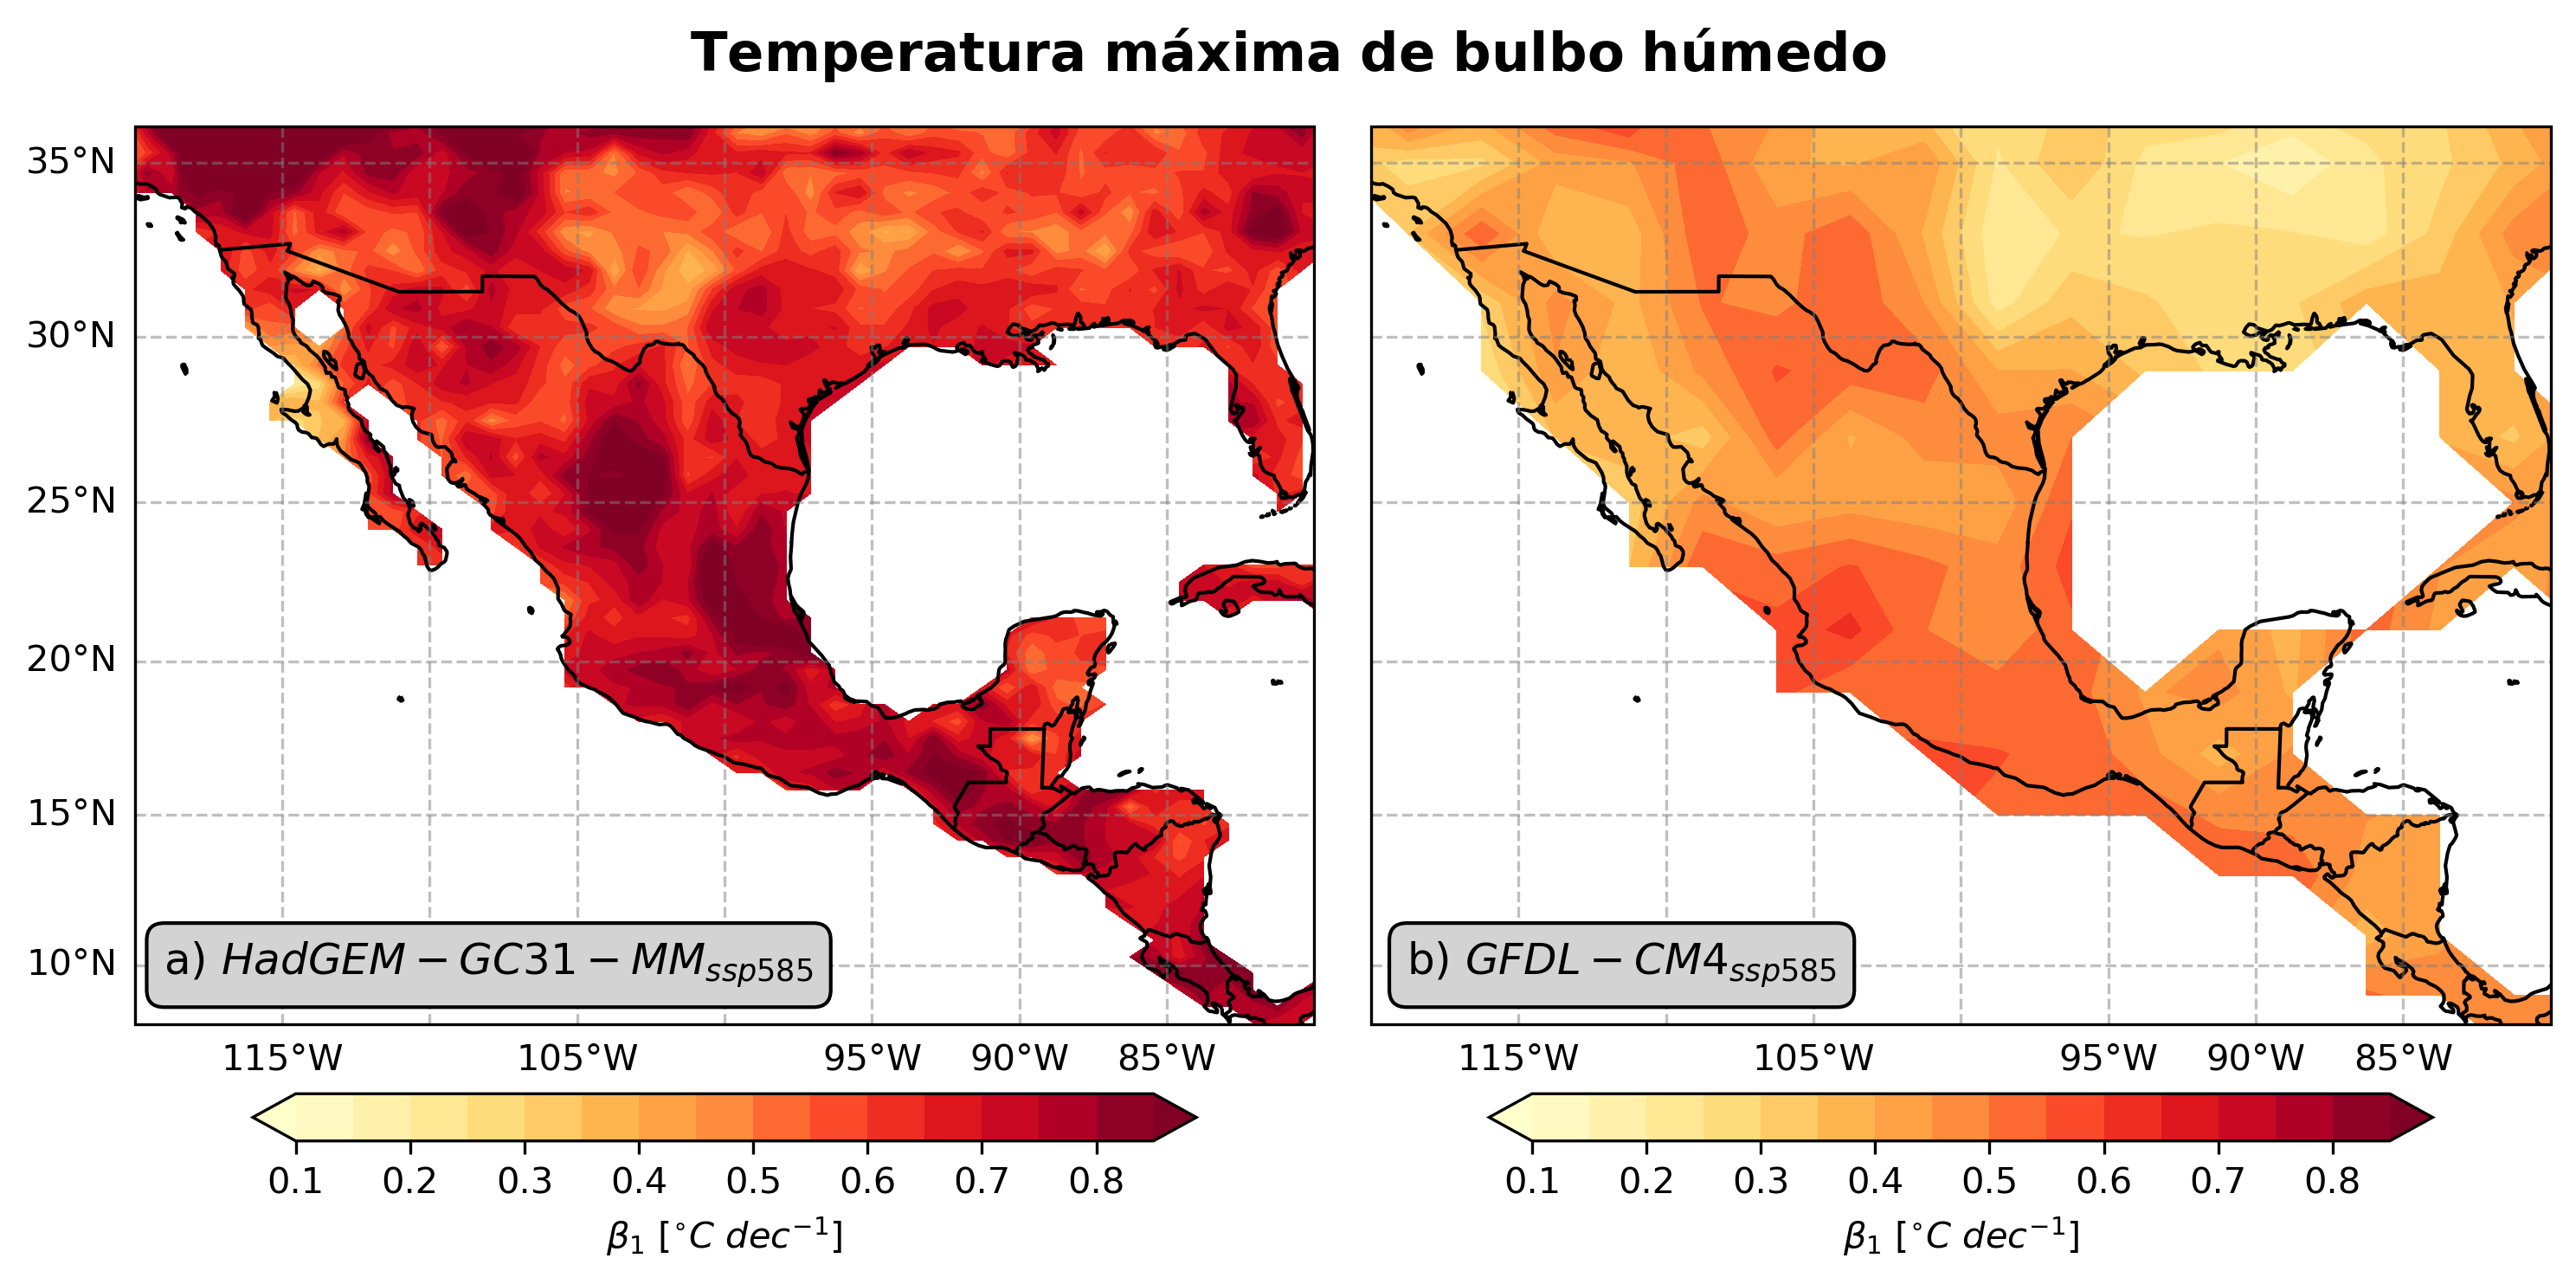

In [16]:
fig = plt.figure(figsize=(10, 7),dpi=300)
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Mercator())

ax.set_extent([-120, -80, 8, 36], crs=ccrs.PlateCarree()) 
ax.set_global

levelss=np.arange(0.1,0.9,0.05)
x=arrF.lon
y=arrF.lat
c=arrF*10
cs=ax.contourf(x,y,c,cmap="YlOrRd",levels=levelss,extend='both',transform=ccrs.PlateCarree())
cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.1,extend="both",label=r"$\beta_{1}$ [$^{\circ}C$ $dec^{-1}$]",shrink=0.8,pad=0.04)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray',alpha=0.5, linestyle='--')
ax.xlabels_top = False
gl.top_labels = gl.right_labels = False
plt.text(-108, 10, "a) $HadGEM-GC31-MM_{ssp585}$", fontsize=12, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4),
        transform=ccrs.PlateCarree())


ax = fig.add_subplot(1, 2, 2, projection=ccrs.Mercator())
ax.set_extent([-120, -80, 8, 36], crs=ccrs.PlateCarree()) 
ax.set_global
ax.add_feature(cfeature.BORDERS)

x=arrF2.lon
y=arrF2.lat
c=arrF2*10
cs=ax.contourf(x,y,c,cmap="YlOrRd",levels=levelss,extend='both',transform=ccrs.PlateCarree())
cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.1,label=r"$\beta_{1}$ [$^{\circ}C$ $dec^{-1}$]",extend="both",shrink=0.8,pad=0.04)
ax.coastlines()
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')

gl.top_labels = gl.right_labels = False
gl.left_labels=False

plt.text(-111.5, 10, "b) $GFDL-CM4_{ssp585}$", fontsize=12, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4),
        transform=ccrs.PlateCarree())
   
plt.tight_layout(pad=1)
plt.suptitle(r"$\mathbf{Temperatura}$ $\mathbf{máxima}$ $\mathbf{de}$ $\mathbf{bulbo}$ $\mathbf{húmedo}$",fontsize=15,y=0.71)
plt.savefig("trend_models.svg",bbox_inches="tight",dpi=300)
plt.savefig("trend_models.png",bbox_inches="tight",dpi=300)
plt.show()